# Using PyTorch and MONAI for MRI Alzheimer's Classification

In [1]:
import logging
import os
import sys
from tqdm.notebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ImageDataset
from monai.transforms import AddChannel, Compose, SpatialCrop, Resize, ScaleIntensity, EnsureType, RandRotate90

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, roc_auc_score

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.0
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
from sklearn.utils import shuffle

def generate_filenames(labels=['control', 'dementia']):
    pairs = []
    
    for label in labels:
        label_dir = os.path.join('/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "nii.gz" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            pairs.append([img_path, i])
    
    m = len(pairs)
    filenames = []
    labels = np.zeros(m, dtype=np.int64)
    
    idx = 0
    for filename, label in pairs:
        filenames.append(filename)
        labels[idx] = label
        idx += 1
    
    filenames = np.array(filenames)
    filenames, labels = shuffle(filenames, labels)
    return filenames, labels
        

X_filenames, y_labels = generate_filenames()

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

In [3]:
# There are two labels: 0 represents control patients, and 1 represents dementia patients
for idx in range(len(X_filenames)):
    if idx < 10:
        print(y_labels[idx], X_filenames[idx])
    dementia = "dementia" in X_filenames[idx]
    label = y_labels[idx]
    if int(dementia) != label:
        print("Bad: ", X_filenames[idx], label)

1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30433_MR_d1954/OAS30433.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS31158_MR_d2481/OAS31158.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30352_MR_d0099/OAS30352.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30289_MR_d0160/OAS30289.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30512_MR_d0353/OAS30512.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30614_MR_d1464/OAS30614.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS31125_MR_d0735/OAS31125.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30004_MR_d2232/OAS30004.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30857_MR_d0058/OAS30857.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30841_MR_d0187/OAS30841.nii.gz


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filenames, y_labels, test_size=.25, shuffle=True)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(766,) (256,) (766,) (256,)


In [6]:
from collections import Counter
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print(counter_train, (counter_train[0] / (counter_train[0] + counter_train[1]),
                     (counter_train[1] / (counter_train[0] + counter_train[1]))))
print(counter_test, (counter_test[0] / (counter_test[0] + counter_test[1]),
                     (counter_test[1] / (counter_test[0] + counter_test[1]))))

Counter({0: 536, 1: 230}) (0.6997389033942559, 0.3002610966057441)
Counter({0: 176, 1: 80}) (0.6875, 0.3125)


In [7]:
# Validate the train and val sets
for idx in range(len(X_train)):
    dementia = "dementia" in X_train[idx]
    label = y_train[idx]
    if int(dementia) != label:
        print("Bad: ", X_train, y_train)

for idx in range(len(X_test)):
    dementia = "dementia" in X_test[idx]
    label = y_test[idx]
    if int(dementia) != label:
        print("Bad: ", X_test, y_test)

In [8]:
# define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((128,128,128)), SpatialCrop(roi_start=(15, 15, 0), roi_end=(110,110,110)), RandRotate90(), EnsureType()])
val_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((128,128,128)), SpatialCrop(roi_start=(15, 15, 0), roi_end=(110,110,110)), EnsureType()])

In [9]:
# Check the dataset
check_ds = ImageDataset(image_files=X_filenames, labels=y_labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=5, num_workers=12, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

<class 'torch.Tensor'> torch.Size([5, 1, 95, 95, 110]) tensor([1, 0, 0, 0, 0])


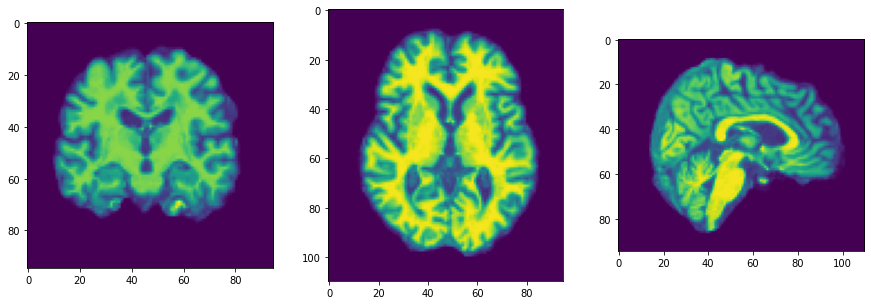

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(np.rot90(im[0, 0, :, :, int(110/2)], 3))
ax[1].imshow(np.rot90(im[0, 0, :, int(95/2), :]))
ax[2].imshow(im[0, 0, int(95/2), :, :])

In [11]:
from IPython import display as dspl
import ipywidgets as widgets

# graphs the MRI image
def show_graph(img, height, width, depth, color, patient):
    # Plots brain scans in all three dimensions
    fig, ax = plt.subplots(1, 3, figsize=(15,7))
    pat_types = ['control', 'dementia']
    print(pat_types[label[patient]])
    print(img.shape)

    ax[0].set_title("height")
    ax[1].set_title("width")
    ax[2].set_title("depth")

    colormap = 'gray' if color == 'Gray' else 'viridis'
    ax[0].imshow(img[patient, 0, height, :, :], cmap=colormap)
    ax[1].imshow(np.rot90(img[patient, 0, :, width, :]), cmap=colormap)
    ax[2].imshow(np.rot90(img[patient, 0, :, :, depth], 3), cmap=colormap)
    

def disp(pat_type, image_data):
    num_pats, _, height, width, depth  = image_data.shape
    co = widgets.ToggleButtons(options=['Gray', 'Color'], description='Color Map')
    hi = widgets.IntSlider(value=height/2, max=height-1, continous_updates=False, description='View 1')
    wi = widgets.IntSlider(value=width/2, max=width-1, continous_updates=False, description='View 2')
    de = widgets.IntSlider(value=depth/2, max=depth-1, continous_updates=False, description='View 3')
    pat = widgets.Dropdown(options=range(num_pats), value=0, description='Patient Number')
    ui = widgets.HBox([hi, wi, de, co, pat])
    
    display_output = widgets.interactive_output(show_graph, {'img':widgets.fixed(image_data),
                                                             'height':hi,
                                                             'width':wi,
                                                             'depth':de,
                                                             'color':co,
                                                             'patient':pat})
    dspl.display(ui, display_output)

disp(label[0], im)

Output()

In [12]:
# create a training data loader
train_ds = ImageDataset(image_files=X_train, labels=y_train, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=12, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(image_files=X_test, labels=y_test, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=5, num_workers=12, pin_memory=torch.cuda.is_available())

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
# Create class weights
(unique, counts) = np.unique(y_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

# 0 is control, 1 is dementia
control_cnt = frequencies[0,1]
dementia_cnt = frequencies[1,1]
total_cnt = control_cnt + dementia_cnt
print(control_cnt, dementia_cnt, total_cnt)

weight_for_0 = (1 / control_cnt) * (total_cnt / 2.0)
weight_for_1 = (1 / dementia_cnt) * (total_cnt / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

class_weights = torch.FloatTensor([weight_for_0, weight_for_1]).to(device)
print(class_weights)

[[  0 712]
 [  1 310]]
69.67% of the data is control
712 310 1022
{0: 0.7176966292134831, 1: 1.6483870967741936}
tensor([0.7177, 1.6484], device='cuda:0')


In [15]:
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [16]:
!rm -rf runs

In [17]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
n_epochs = 50

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

----------
epoch 1/50
epoch 1 average loss: 0.6589
Saved new best metric model: best metric of 0.6096590909090909
epoch: 1, accuracy: 0.7070, balanced_acc: 0.6097, AUC: 0.6097, precision: 0.5490, recall: 0.3500
best epoch: 1, best accuracy: 0.6096590909090909


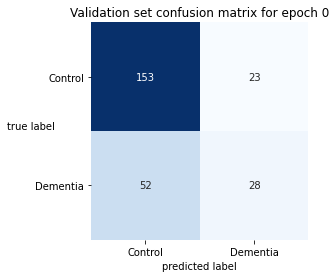

----------
epoch 2/50
epoch 2 average loss: 0.6135
Saved new best metric model: best metric of 0.6363636363636364
epoch: 2, accuracy: 0.6875, balanced_acc: 0.6364, AUC: 0.6364, precision: 0.5000, recall: 0.5000
best epoch: 2, best accuracy: 0.6363636363636364


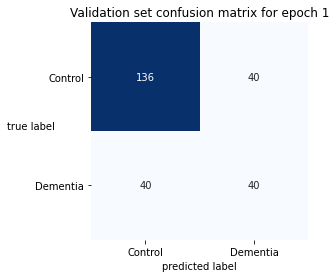

----------
epoch 3/50
epoch 3 average loss: 0.5874
Saved new best metric model: best metric of 0.6880681818181817
epoch: 3, accuracy: 0.6602, balanced_acc: 0.6881, AUC: 0.6881, precision: 0.4729, recall: 0.7625
best epoch: 3, best accuracy: 0.6880681818181817


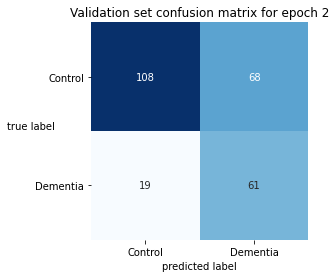

----------
epoch 4/50
epoch 4 average loss: 0.5602
epoch: 4, accuracy: 0.6875, balanced_acc: 0.6875, AUC: 0.6875, precision: 0.5000, recall: 0.6875
best epoch: 3, best accuracy: 0.6880681818181817


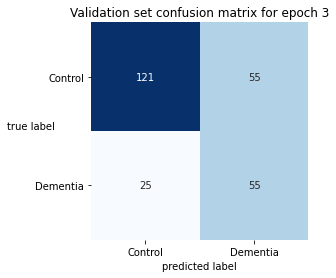

----------
epoch 5/50
epoch 5 average loss: 0.5441
epoch: 5, accuracy: 0.7070, balanced_acc: 0.6778, AUC: 0.6778, precision: 0.5275, recall: 0.6000
best epoch: 3, best accuracy: 0.6880681818181817


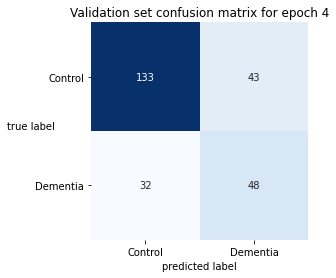

----------
epoch 6/50
epoch 6 average loss: 0.4925
epoch: 6, accuracy: 0.7266, balanced_acc: 0.6409, AUC: 0.6409, precision: 0.5893, recall: 0.4125
best epoch: 3, best accuracy: 0.6880681818181817


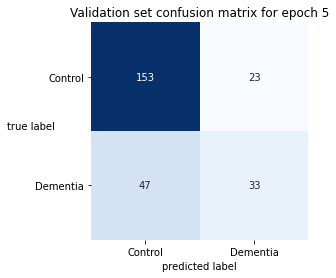

----------
epoch 7/50
epoch 7 average loss: 0.4576
Saved new best metric model: best metric of 0.7210227272727273
epoch: 7, accuracy: 0.6680, balanced_acc: 0.7210, AUC: 0.7210, precision: 0.4825, recall: 0.8625
best epoch: 7, best accuracy: 0.7210227272727273


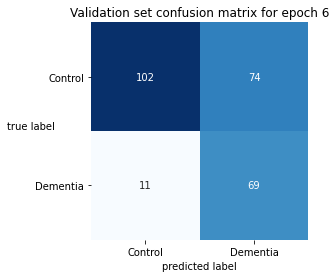

----------
epoch 8/50
epoch 8 average loss: 0.3837
Saved new best metric model: best metric of 0.727840909090909
epoch: 8, accuracy: 0.6914, balanced_acc: 0.7278, AUC: 0.7278, precision: 0.5038, recall: 0.8250
best epoch: 8, best accuracy: 0.727840909090909


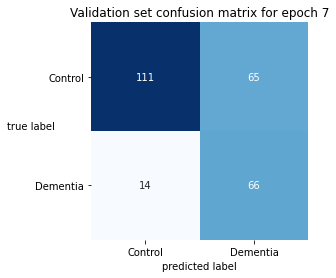

----------
epoch 9/50
epoch 9 average loss: 0.3476
epoch: 9, accuracy: 0.5352, balanced_acc: 0.6449, AUC: 0.6449, precision: 0.3968, recall: 0.9375
best epoch: 8, best accuracy: 0.727840909090909


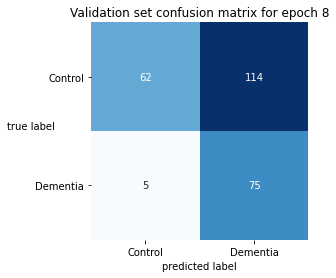

----------
epoch 10/50
epoch 10 average loss: 0.2726
epoch: 10, accuracy: 0.4609, balanced_acc: 0.5909, AUC: 0.5909, precision: 0.3606, recall: 0.9375
best epoch: 8, best accuracy: 0.727840909090909


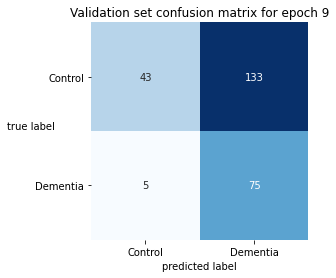

----------
epoch 11/50
epoch 11 average loss: 0.2597
epoch: 11, accuracy: 0.7070, balanced_acc: 0.5312, AUC: 0.5312, precision: 1.0000, recall: 0.0625
best epoch: 8, best accuracy: 0.727840909090909


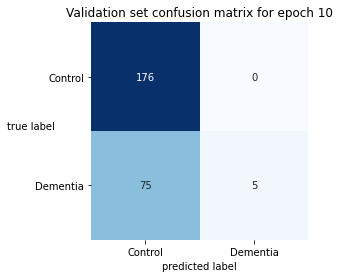

----------
epoch 12/50
epoch 12 average loss: 0.2706
epoch: 12, accuracy: 0.5117, balanced_acc: 0.6278, AUC: 0.6278, precision: 0.3846, recall: 0.9375
best epoch: 8, best accuracy: 0.727840909090909


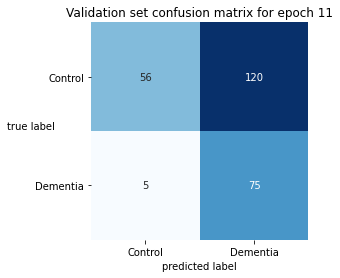

----------
epoch 13/50
epoch 13 average loss: 0.2681
epoch: 13, accuracy: 0.6953, balanced_acc: 0.6352, AUC: 0.6352, precision: 0.5135, recall: 0.4750
best epoch: 8, best accuracy: 0.727840909090909


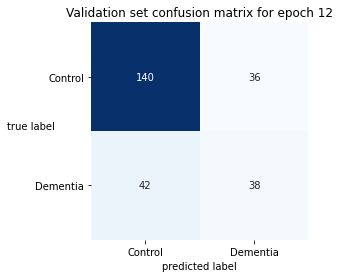

----------
epoch 14/50
epoch 14 average loss: 0.2708
epoch: 14, accuracy: 0.6797, balanced_acc: 0.7159, AUC: 0.7159, precision: 0.4924, recall: 0.8125
best epoch: 8, best accuracy: 0.727840909090909


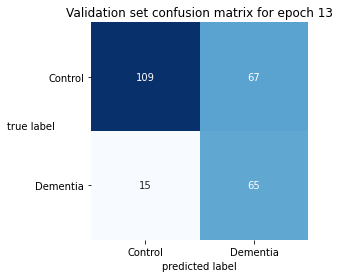

----------
epoch 15/50
epoch 15 average loss: 0.2093
epoch: 15, accuracy: 0.7539, balanced_acc: 0.6506, AUC: 0.6506, precision: 0.6977, recall: 0.3750
best epoch: 8, best accuracy: 0.727840909090909


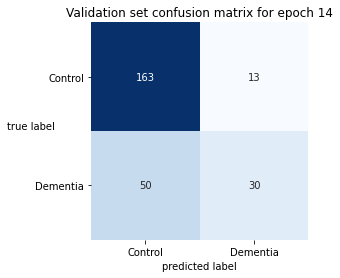

----------
epoch 16/50
epoch 16 average loss: 0.2136
epoch: 16, accuracy: 0.7109, balanced_acc: 0.6466, AUC: 0.6466, precision: 0.5429, recall: 0.4750
best epoch: 8, best accuracy: 0.727840909090909


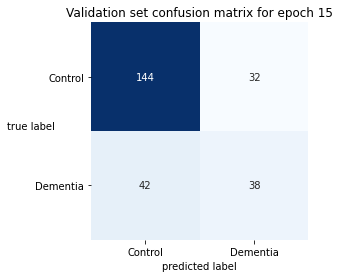

----------
epoch 17/50
epoch 17 average loss: 0.2062
epoch: 17, accuracy: 0.6680, balanced_acc: 0.7244, AUC: 0.7244, precision: 0.4828, recall: 0.8750
best epoch: 8, best accuracy: 0.727840909090909


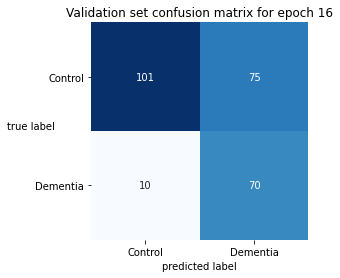

----------
epoch 18/50
epoch 18 average loss: 0.2050
epoch: 18, accuracy: 0.6562, balanced_acc: 0.7023, AUC: 0.7023, precision: 0.4714, recall: 0.8250
best epoch: 8, best accuracy: 0.727840909090909


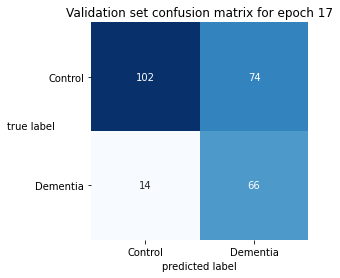

----------
epoch 19/50
epoch 19 average loss: 0.2095
epoch: 19, accuracy: 0.7500, balanced_acc: 0.6955, AUC: 0.6955, precision: 0.6111, recall: 0.5500
best epoch: 8, best accuracy: 0.727840909090909


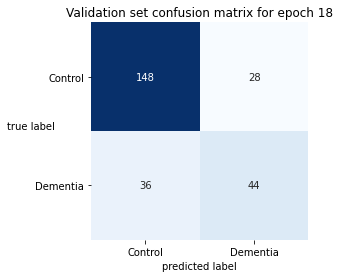

----------
epoch 20/50
epoch 20 average loss: 0.1828
epoch: 20, accuracy: 0.7031, balanced_acc: 0.7159, AUC: 0.7159, precision: 0.5172, recall: 0.7500
best epoch: 8, best accuracy: 0.727840909090909


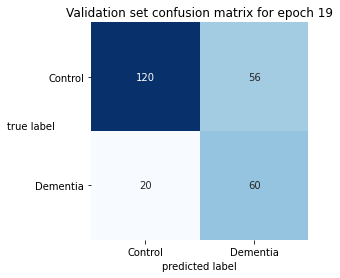

----------
epoch 21/50
epoch 21 average loss: 0.1624
epoch: 21, accuracy: 0.7227, balanced_acc: 0.5801, AUC: 0.5801, precision: 0.6957, recall: 0.2000
best epoch: 8, best accuracy: 0.727840909090909


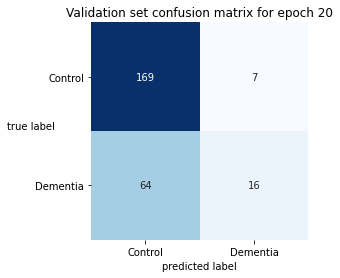

----------
epoch 22/50
epoch 22 average loss: 0.1802
epoch: 22, accuracy: 0.7344, balanced_acc: 0.6909, AUC: 0.6909, precision: 0.5750, recall: 0.5750
best epoch: 8, best accuracy: 0.727840909090909


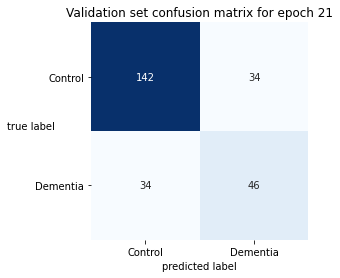

----------
epoch 23/50
epoch 23 average loss: 0.1792
epoch: 23, accuracy: 0.7539, balanced_acc: 0.6915, AUC: 0.6915, precision: 0.6269, recall: 0.5250
best epoch: 8, best accuracy: 0.727840909090909


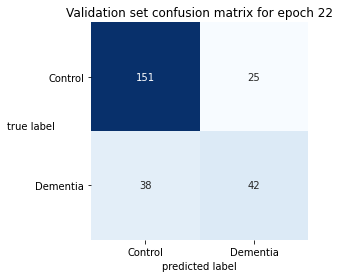

----------
epoch 24/50
epoch 24 average loss: 0.1680
epoch: 24, accuracy: 0.7617, balanced_acc: 0.7176, AUC: 0.7176, precision: 0.6234, recall: 0.6000
best epoch: 8, best accuracy: 0.727840909090909


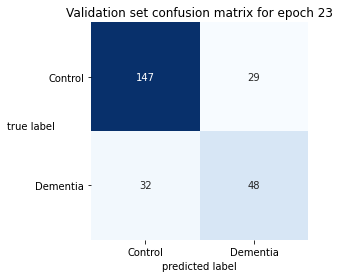

----------
epoch 25/50
epoch 25 average loss: 0.1963
epoch: 25, accuracy: 0.6641, balanced_acc: 0.7216, AUC: 0.7216, precision: 0.4795, recall: 0.8750
best epoch: 8, best accuracy: 0.727840909090909


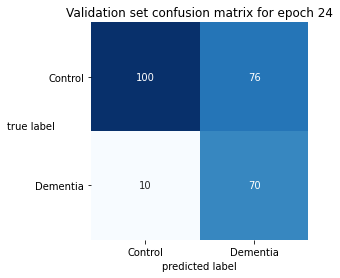

----------
epoch 26/50
epoch 26 average loss: 0.1298
epoch: 26, accuracy: 0.6914, balanced_acc: 0.7176, AUC: 0.7176, precision: 0.5040, recall: 0.7875
best epoch: 8, best accuracy: 0.727840909090909


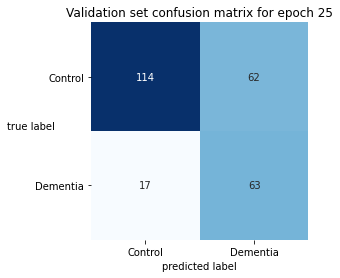

----------
epoch 27/50
epoch 27 average loss: 0.1704
epoch: 27, accuracy: 0.7266, balanced_acc: 0.7057, AUC: 0.7057, precision: 0.5532, recall: 0.6500
best epoch: 8, best accuracy: 0.727840909090909


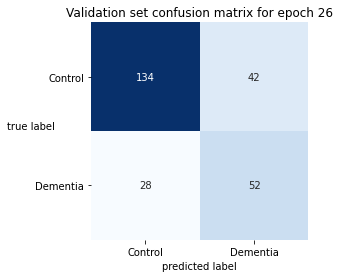

----------
epoch 28/50
epoch 28 average loss: 0.1430
epoch: 28, accuracy: 0.7422, balanced_acc: 0.6659, AUC: 0.6659, precision: 0.6167, recall: 0.4625
best epoch: 8, best accuracy: 0.727840909090909


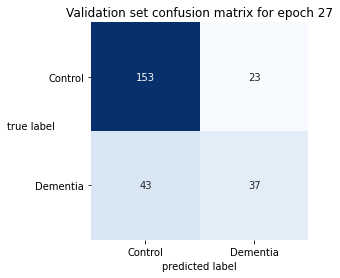

----------
epoch 29/50
epoch 29 average loss: 0.1637
epoch: 29, accuracy: 0.7578, balanced_acc: 0.7182, AUC: 0.7182, precision: 0.6125, recall: 0.6125
best epoch: 8, best accuracy: 0.727840909090909


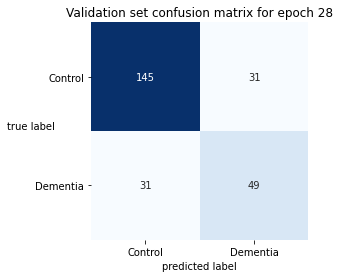

----------
epoch 30/50
epoch 30 average loss: 0.1609
epoch: 30, accuracy: 0.7188, balanced_acc: 0.6795, AUC: 0.6795, precision: 0.5476, recall: 0.5750
best epoch: 8, best accuracy: 0.727840909090909


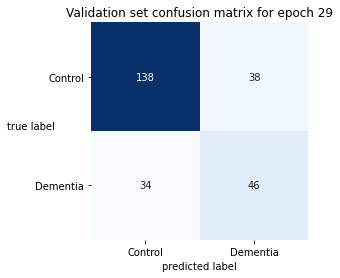

----------
epoch 31/50
epoch 31 average loss: 0.1484
epoch: 31, accuracy: 0.7305, balanced_acc: 0.7051, AUC: 0.7051, precision: 0.5604, recall: 0.6375
best epoch: 8, best accuracy: 0.727840909090909


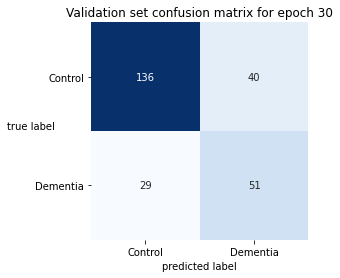

----------
epoch 32/50
epoch 32 average loss: 0.1441
epoch: 32, accuracy: 0.6602, balanced_acc: 0.7119, AUC: 0.7119, precision: 0.4755, recall: 0.8500
best epoch: 8, best accuracy: 0.727840909090909


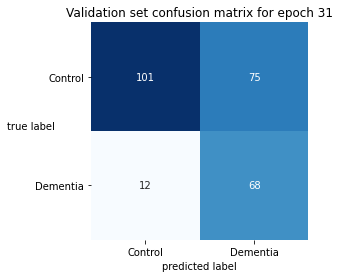

----------
epoch 33/50
epoch 33 average loss: 0.1559
epoch: 33, accuracy: 0.7305, balanced_acc: 0.6199, AUC: 0.6199, precision: 0.6341, recall: 0.3250
best epoch: 8, best accuracy: 0.727840909090909


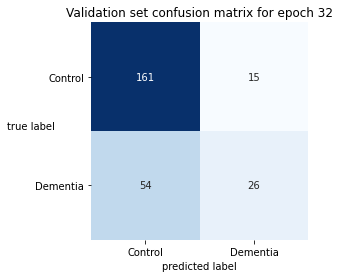

----------
epoch 34/50
epoch 34 average loss: 0.1383
epoch: 34, accuracy: 0.7461, balanced_acc: 0.6347, AUC: 0.6347, precision: 0.6923, recall: 0.3375
best epoch: 8, best accuracy: 0.727840909090909


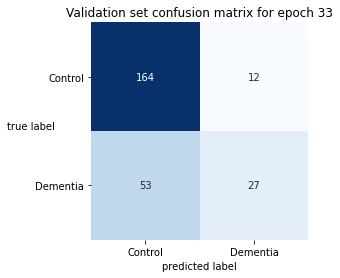

----------
epoch 35/50
epoch 35 average loss: 0.1171
Saved new best metric model: best metric of 0.7318181818181818
epoch: 35, accuracy: 0.7344, balanced_acc: 0.7318, AUC: 0.7318, precision: 0.5577, recall: 0.7250
best epoch: 35, best accuracy: 0.7318181818181818


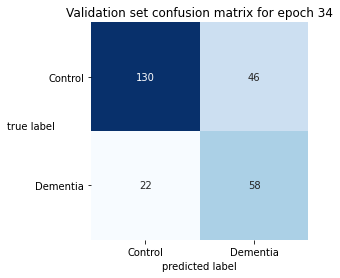

----------
epoch 36/50
epoch 36 average loss: 0.1634
epoch: 36, accuracy: 0.7344, balanced_acc: 0.5784, AUC: 0.5784, precision: 0.9286, recall: 0.1625
best epoch: 35, best accuracy: 0.7318181818181818


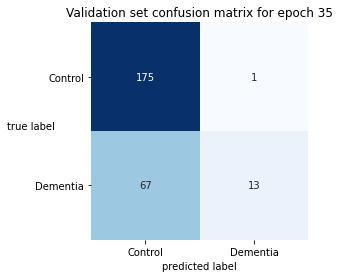

----------
epoch 37/50
epoch 37 average loss: 0.1240
epoch: 37, accuracy: 0.7578, balanced_acc: 0.6909, AUC: 0.6909, precision: 0.6406, recall: 0.5125
best epoch: 35, best accuracy: 0.7318181818181818


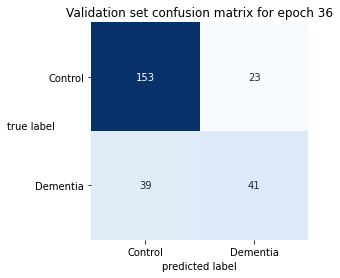

----------
epoch 38/50
epoch 38 average loss: 0.0954
epoch: 38, accuracy: 0.7656, balanced_acc: 0.6659, AUC: 0.6659, precision: 0.7273, recall: 0.4000
best epoch: 35, best accuracy: 0.7318181818181818


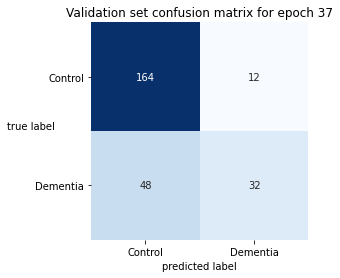

----------
epoch 39/50
epoch 39 average loss: 0.1346
epoch: 39, accuracy: 0.7461, balanced_acc: 0.6415, AUC: 0.6415, precision: 0.6744, recall: 0.3625
best epoch: 35, best accuracy: 0.7318181818181818


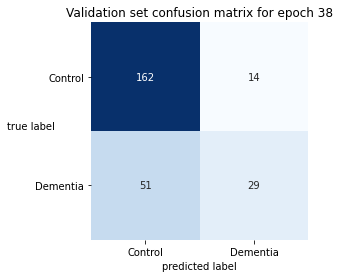

----------
epoch 40/50
epoch 40 average loss: 0.1189
epoch: 40, accuracy: 0.6172, balanced_acc: 0.6943, AUC: 0.6943, precision: 0.4444, recall: 0.9000
best epoch: 35, best accuracy: 0.7318181818181818


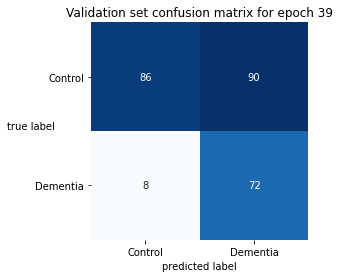

----------
epoch 41/50
epoch 41 average loss: 0.1153
epoch: 41, accuracy: 0.6445, balanced_acc: 0.6972, AUC: 0.6972, precision: 0.4621, recall: 0.8375
best epoch: 35, best accuracy: 0.7318181818181818


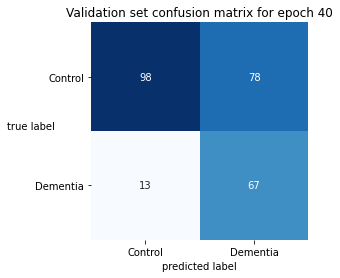

----------
epoch 42/50
epoch 42 average loss: 0.1438
epoch: 42, accuracy: 0.7578, balanced_acc: 0.6773, AUC: 0.6773, precision: 0.6607, recall: 0.4625
best epoch: 35, best accuracy: 0.7318181818181818


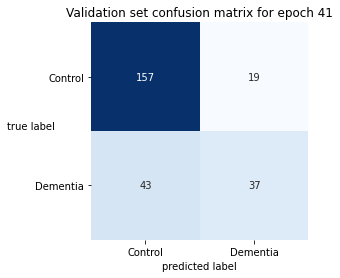

----------
epoch 43/50
epoch 43 average loss: 0.1417
epoch: 43, accuracy: 0.7109, balanced_acc: 0.7318, AUC: 0.7318, precision: 0.5250, recall: 0.7875
best epoch: 35, best accuracy: 0.7318181818181818


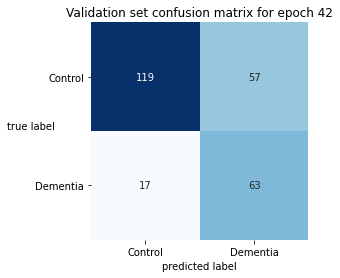

----------
epoch 44/50
epoch 44 average loss: 0.1170
epoch: 44, accuracy: 0.7344, balanced_acc: 0.5955, AUC: 0.5955, precision: 0.7500, recall: 0.2250
best epoch: 35, best accuracy: 0.7318181818181818


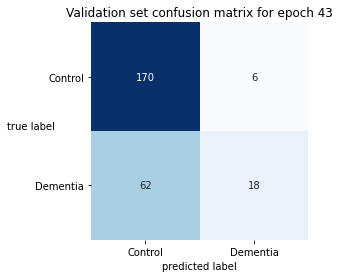

----------
epoch 45/50
epoch 45 average loss: 0.1269
epoch: 45, accuracy: 0.7852, balanced_acc: 0.7176, AUC: 0.7176, precision: 0.7049, recall: 0.5375
best epoch: 35, best accuracy: 0.7318181818181818


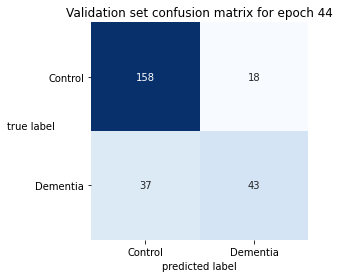

----------
epoch 46/50
epoch 46 average loss: 0.1188
epoch: 46, accuracy: 0.6172, balanced_acc: 0.6875, AUC: 0.6875, precision: 0.4430, recall: 0.8750
best epoch: 35, best accuracy: 0.7318181818181818


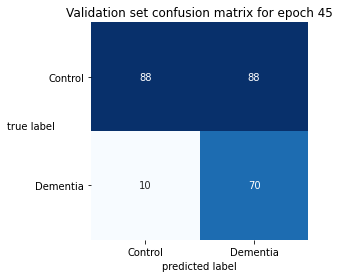

----------
epoch 47/50
epoch 47 average loss: 0.0892
epoch: 47, accuracy: 0.7500, balanced_acc: 0.7091, AUC: 0.7091, precision: 0.6000, recall: 0.6000
best epoch: 35, best accuracy: 0.7318181818181818


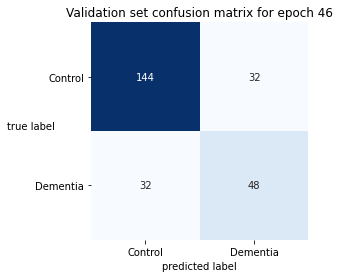

----------
epoch 48/50
epoch 48 average loss: 0.0920
epoch: 48, accuracy: 0.7383, balanced_acc: 0.7176, AUC: 0.7176, precision: 0.5699, recall: 0.6625
best epoch: 35, best accuracy: 0.7318181818181818


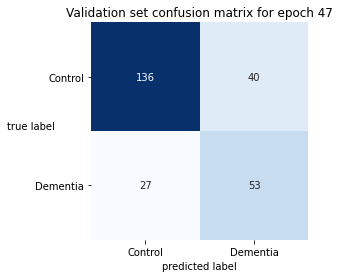

----------
epoch 49/50
epoch 49 average loss: 0.0935
epoch: 49, accuracy: 0.7148, balanced_acc: 0.7278, AUC: 0.7278, precision: 0.5304, recall: 0.7625
best epoch: 35, best accuracy: 0.7318181818181818


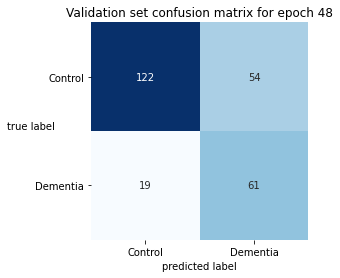

----------
epoch 50/50
epoch 50 average loss: 0.0788
epoch: 50, accuracy: 0.7188, balanced_acc: 0.7136, AUC: 0.7136, precision: 0.5385, recall: 0.7000
best epoch: 35, best accuracy: 0.7318181818181818


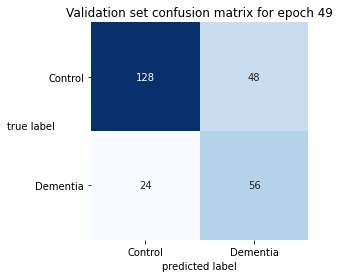

train completed, best_metric: 0.7318 at epoch: 35


In [18]:
# start a typical PyTorch training
for epoch in tqdm(range(n_epochs), desc='Epoch'):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{n_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}", end='\r')
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            iteration = 0
            leng = len(val_loader)
            for val_data in val_loader:
                print(f'Reading validation set: {iteration}/{leng}', end='\r')
                iteration += 1

                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            predictions = y_pred.argmax(dim=1).cpu()
            actual = y.cpu()

            # Accuracy
            acc = accuracy_score(actual, predictions)
            balanced_acc = balanced_accuracy_score(actual, predictions)
            # Check if accuracy is better
            if balanced_acc > best_metric:
                best_metric = balanced_acc
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_dict.pth")
                print(f"Saved new best metric model: best metric of {best_metric}")
            writer.add_scalar("val_accuracy", acc, epoch + 1)
            writer.add_scalar("val_balanced_accuracy", balanced_acc, epoch + 1)

            # ROC-AUC
            auc_result = roc_auc_score(actual, predictions)

            # Precision
            precision = 0
            if 1 in predictions:
                precision = precision_score(actual, predictions)
            writer.add_scalar("val_precision", precision, epoch + 1)

            # Recall
            recall = recall_score(actual, predictions)
            writer.add_scalar("val_recall", recall, epoch + 1)
            
            print(f"epoch: {epoch+1}, accuracy: {acc:.4f}, balanced_acc: {balanced_acc:.4f}, AUC: {auc_result:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
            print(f"best epoch: {best_metric_epoch}, best accuracy: {best_metric}")

            # Confusion matrix
            cm = confusion_matrix(actual, predictions)

            fig, ax = plt.subplots()
            sns.heatmap(cm, ax=ax, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
            ax.set_xlabel('predicted label')
            ax.set_ylabel('true label', rotation=0)
            ax.set_xticklabels(['Control', 'Dementia'], rotation=0)
            ax.set_yticklabels(['Control', 'Dementia'], rotation=0)
            ax.set_title(f'Validation set confusion matrix for epoch {epoch}')
            plt.show()

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

In [21]:
eval_model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
eval_model.load_state_dict(torch.load("/home/jack/Code/GitHub/Polygence/CNN/best_metric_model_classification3d_dict.pth"))
eval_model.eval()

DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [32]:
def evaluate(device, model, loader):
    model.eval()
    with torch.no_grad():
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)

        iteration = 0
        leng = len(loader)
        for val_data in loader:
            print(f'Reading set: {iteration}/{leng}', end='\r')
            iteration += 1

            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            y_pred = torch.cat([y_pred, model(val_images)], dim=0)
            y = torch.cat([y, val_labels], dim=0)

        predictions = y_pred.argmax(dim=1).cpu()
        actual = y.cpu()

        # Accuracy
        acc = accuracy_score(actual, predictions)
        balanced_acc = balanced_accuracy_score(actual, predictions)

        # ROC-AUC
        auc_result = roc_auc_score(actual, predictions)

        # Precision
        precision = 0
        if 1 in predictions:
            precision = precision_score(actual, predictions)

        # Recall
        recall = recall_score(actual, predictions)

        print(f"accuracy: {acc:.4f}, balanced_acc: {balanced_acc:.4f}, AUC: {auc_result:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

        # Confusion matrix
        cm = confusion_matrix(actual, predictions)

        fig, ax = plt.subplots()
        sns.heatmap(cm, ax=ax, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
        ax.set_xlabel('predicted label')
        ax.set_ylabel('true label', rotation=0)
        ax.set_xticklabels(['Control', 'Dementia'], rotation=0)
        ax.set_yticklabels(['Control', 'Dementia'], rotation=0)
        ax.set_title(f'Validation set confusion matrix for epoch {epoch}')
        plt.show()

accuracy: 0.7344, balanced_acc: 0.7318, AUC: 0.7318, precision: 0.5577, recall: 0.7250


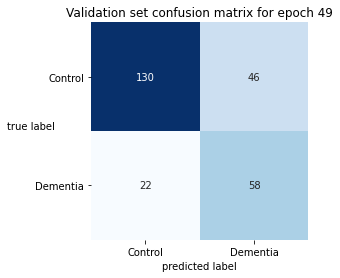

In [33]:
evaluate(device, eval_model, val_loader)

accuracy: 0.9556, balanced_acc: 0.9658, AUC: 0.9658, precision: 0.8769, recall: 0.9913


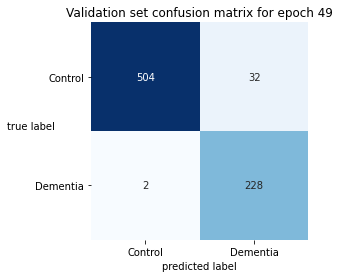

In [34]:
test_train_loader = DataLoader(train_ds, batch_size=5, num_workers=12, pin_memory=torch.cuda.is_available())
evaluate(device, eval_model, test_train_loader)

In [35]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 536]
 [  1 230]]
69.97% of the data is control


In [36]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 176]
 [  1  80]]
68.75% of the data is control
